In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo

# Equations

The equations we are solving are:

\begin{align}
    M_{s1} + M_{s2} + M_{s0} &= M_s ~~~~~ (1)\\
    M_{c1} + M_{c2} + M_{c0} &= M_c ~~~~~ (2) \\
    M_{s1}\delta_1 + M_{s2}\delta_2 + M_{s0}\delta_{s0} &= M_s\delta_s ~~~~~ (3) \\
    M_{c1}\delta_1 + M_{c2}\delta_2 + M_{c0}\delta_{c0} &= M_c\delta_c ~~~~~ (4) \\
\end{align}

Also, we have that all $M>0$.

# Analysis 

Want to solve for $M_{s1}, M_{s2}, M_{c1}, M_{c2}$ as well as find $\delta_1$ and $\delta_2$ such that the equations and inequalities are all satisfied.

# Read in data

In [2]:
colnames = ["Number", "Station", "Depth", "Ms", "Mso", "deltas", "Mc", "Mco", "deltac", "Md", "Mdo", "deltad", "other"]
df = pd.read_csv('2019_09_18_Data_KT_fixed.csv', index_col=0, skiprows=[0,1],names=colnames)
df = df.dropna(axis=1)
df

,Station,Depth,Ms,Mso,deltas,Mc,Mco,deltac,Md,Mdo,deltad
Number,,,,,,,,,,,
1,26,2300,0.373,0.257,0.49,0.718,0.372,0.55,1.091,0.629,0.53
2,23,2300,0.387,0.257,0.47,0.616,0.372,0.58,1.002,0.629,0.54
3,21,2300,0.374,0.257,0.40,1.243,0.372,0.35,1.617,0.629,0.36
4,20,2250,0.497,0.257,0.27,1.279,0.372,0.13,1.776,0.629,0.17
5,18,2000,0.257,0.257,0.31,0.372,0.372,0.21,0.629,0.629,0.25
6,20,2450,1.242,0.257,0.38,1.421,0.372,-0.37,2.662,0.629,-0.02
7,18,2500,2.941,0.257,0.35,5.802,0.372,-0.31,8.742,0.629,-0.09
8,18,2450,2.022,0.257,0.33,4.208,0.372,-0.44,6.230,0.629,-0.19
9,26,2675,0.474,0.257,0.64,0.762,0.372,0.33,1.237,0.629,0.45


Set up arrays of $\delta_1$ and $\delta_2$ to find resultant $M$'s.

In [3]:
ndeltas1, ndeltas2 = 50, 60  # number of delta values in each direction
nobs = 12  # number of observations
nvars = 4  # number of variables

d1 = np.linspace(-0.8,-0.4, ndeltas1); d2 = np.linspace(0.5,1.5, ndeltas2)
# d1 = np.linspace(-0.2,-0.6, ndeltas); d2 = np.linspace(-1,1.5, 60)
# d1 = np.linspace(-3,3, ndeltas); d2 = np.linspace(-3,3, ndeltas)
de1, de2 = np.meshgrid(d1, d2) 
delta1 = de1[:,:,np.newaxis].repeat(12, axis=2) 
delta2 = de2[:,:,np.newaxis].repeat(12, axis=2)

# define constants
# Used to be delta0 = 0.25, now split into one for each equation
deltas0 = 0.31
deltac0 = 0.21
Ms0 = df['Mso'].values[0]
Mc0 = df['Mco'].values[0]

# Solve for $M$'s

We solve for $M_{s2}$ by plugging Equation 1 into Equation 3 to get

$$M_{s2} = \frac{1}{\delta_2 - \delta_1} [M_s\delta_s - M_{s0}\delta_{s0} + (M_{s0} - M_s)\delta_1] $$

Then we can get $M_{s1}$ from Equation 1.

Similarly, we solve for $M_{c2}$ by plugging Equation 2 into Equation 4 to get

$$M_{c2} = \frac{1}{\delta_2 - \delta_1} [M_c\delta_c - M_{c0}\delta_{c0} + (M_{c0} - M_c)\delta_1] $$

Then we can get $M_{c1}$ from Equation 2.

Note that if we originally solved for $M_{s1}$ instead of $M_{s2}$ by plugging Equation 1 into 3, we get a similar form but flipped for $\delta_1$ and $\delta_2$, giving us symmetric results.

In [4]:
ddelta = (delta2-delta1)
Ms2 = (df['Ms'].values*df['deltas'].values - Ms0*deltas0 + (Ms0-df['Ms'].values)*delta1)/ddelta;

In [5]:
Ms1 = df['Ms'].values - Ms0 - Ms2 

In [6]:
Mc2 = (df['Mc'].values*df['deltac'].values - Mc0*deltac0 + (Mc0-df['Mc'].values)*delta1)/(delta2-delta1)

In [7]:
Mc1 = df['Mc'].values - Mc0 - Mc2 

In [8]:
outputs = np.stack([Mc1, Mc2, Ms1, Ms2], axis=-1)
# mask out infinite values
outputs = np.ma.masked_where(np.isinf(outputs), outputs)

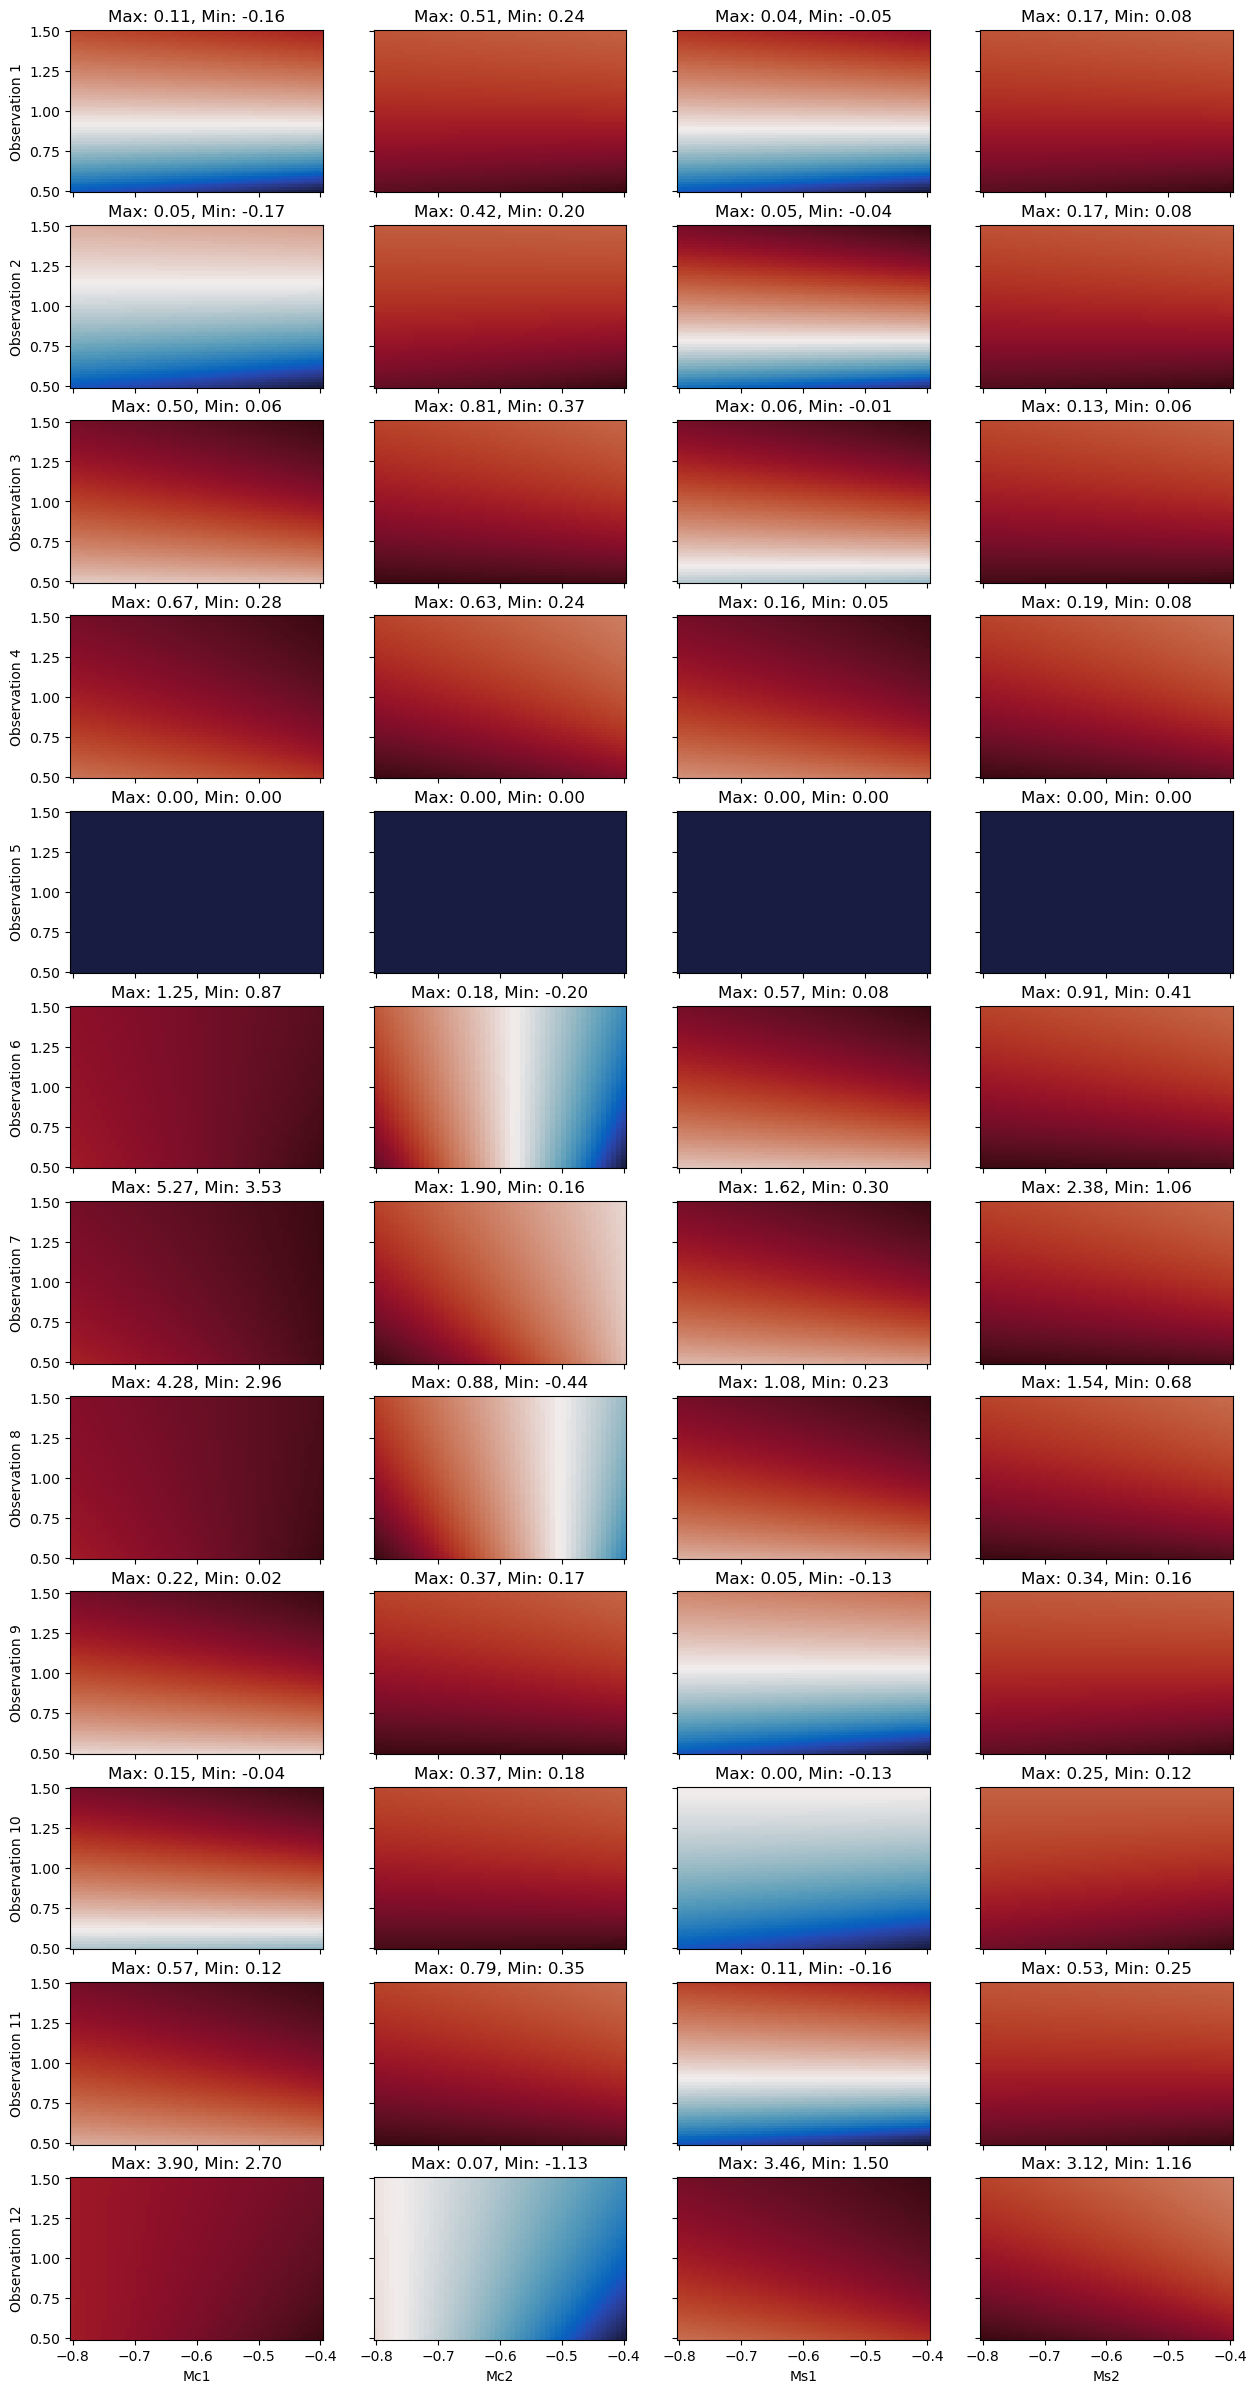

In [9]:
names = ['Mc1', 'Mc2', 'Ms1', 'Ms2']
outputs = np.stack([Mc1, Mc2, Ms1, Ms2], axis=-1)  # nvars x numds x nobs x nvars
# mask out infinite values
outputs = np.ma.masked_where(np.isinf(outputs), outputs)

penalty = np.zeros((ndeltas2, ndeltas1))  # to integrate penalty over the loops

vmax = abs(outputs.max())
vmin = -vmax

fig, axes = plt.subplots(nobs, nvars, sharex=True, sharey=True, figsize=(15,30))

for irow in range(nobs):  # looping over the 12 observations nobs
    for icol in range(nvars):  # looping over the 4 M's we solve for nvars
        ax = axes[irow, icol]
        
        if icol == 0:
            ax.set_ylabel('Observation %i' % (int(irow) + 1))
            
        if irow == nobs-1:
            ax.set_xlabel(names[icol])
            
        var = outputs[:,:,irow,icol].copy()  # rename variable for this loop
                
        # pull out numbers that are <0
        ind = var<0
        # for those numbers, penalty of ^2 for distance away from
        # penalty stores the sum of the penalty squared across the variables (4 M's) and
        # the 12 observations, so over 36 matrices
        penalty[ind] += var[ind]**2
             
        # plot the individual matrices for inspection
        vmax = abs(var).max()
        ax.pcolormesh(delta1[:,:,0], delta2[:,:,0], var, cmap=cmo.balance, vmin=-vmax, vmax=vmax)
#         cb = plt.colorbar(mappable, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.03)

        ax.set_title('Max: %2.2f, Min: %2.2f' % (var.max(), var.min()))
        
# cb = fig.colorbar(mappable, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.03)
# cb.set_label('Value of M variable')

fig, ax = plt.subplots(1, 1, figsize=(10,8))
mappable = ax.contourf(delta1[:,:,0], delta2[:,:,1], np.sqrt(penalty), 15)
ax.set_xlabel('$\delta_1$', fontsize=12)
ax.set_ylabel('$\delta_2$', fontsize=12)
cb = fig.colorbar(mappable)
cb.set_label('penalty', fontsize=14)# Look at penalty

For each variable/observation combination, the distance of the resulting value (for each $\delta_1$, $\delta_2$ pair) is squared and added to the penalty matrix if it is less than zero. Here we plot. The colorbar range is very small in order to zoom into the area of the plot with smallest penalties.

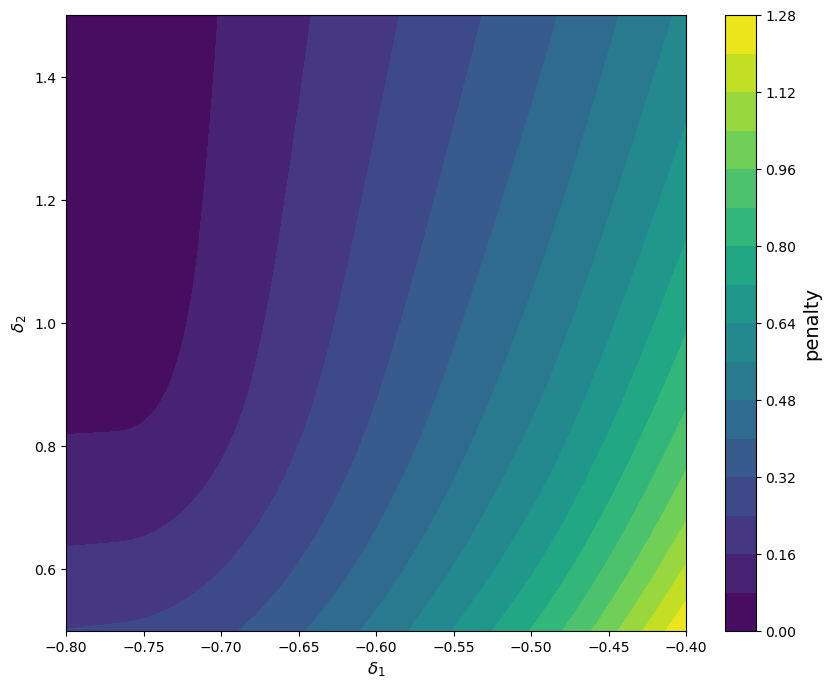

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
mappable = ax.contourf(delta1[:,:,0], delta2[:,:,1], np.sqrt(penalty), 15)
ax.set_xlabel('$\delta_1$', fontsize=12)
ax.set_ylabel('$\delta_2$', fontsize=12)
cb = fig.colorbar(mappable)
cb.set_label('penalty', fontsize=14)

## Histograms of resultant parameters

Here I show a histogram of the full range of each parameter (columns) for each observation (rows) in a lighter color histogram (normalized). Overlaid is the narrower range of parameters resulting from limiting the allowable max value of the square root of the penalty, to show which values of the histogram are associated with lower penalty values.

When a full histogram straddles 0, the histogram with narrower range of values moves to the more positive side.

The narrower range associated with lower penalty also tends to be around the peak of the full histogram, possibly implying the the full histogram of results for each observation and parameter can approximately represent the "best" value with the most common value in the histogram. (this requires more study but looks this way on first glance)

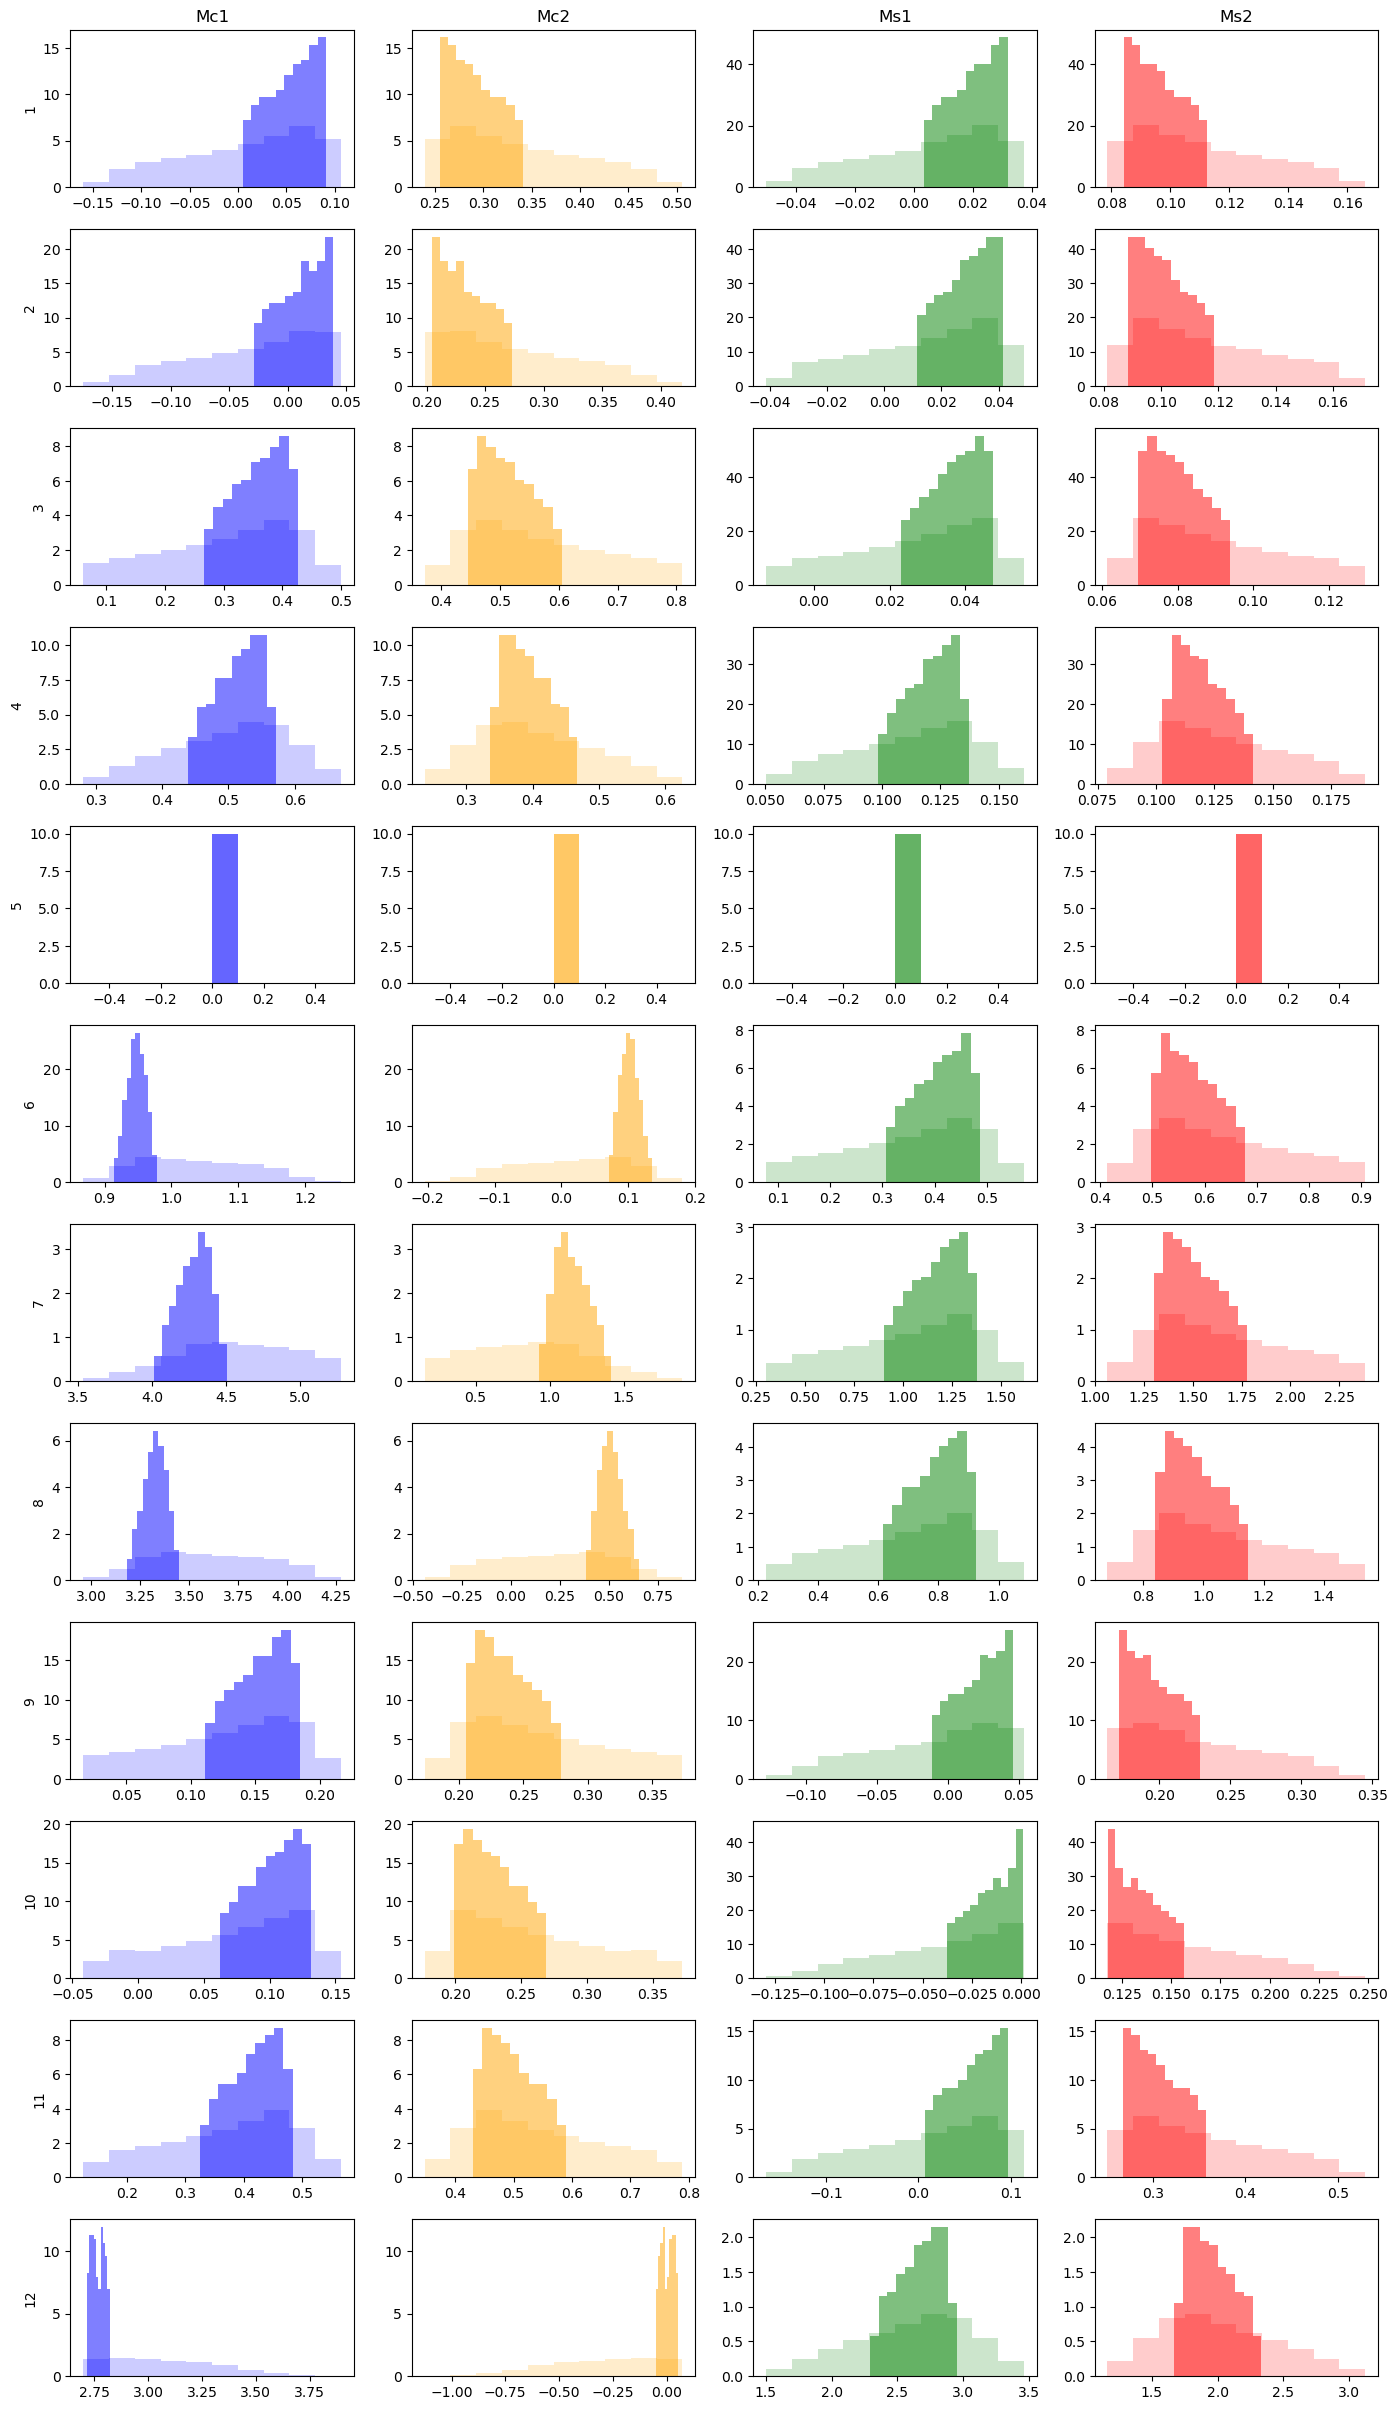

In [11]:
fig, axes = plt.subplots(nobs, 4, figsize=(14,24))#, sharex=True, sharey=True)

for i in range(nobs):
    axes[i,0].hist(Mc1[:,:,i].flat, alpha=0.2, color='b', density=True)
    axes[i,1].hist(Mc2[:,:,i].flat, alpha=0.2, color='orange', density=True)
    axes[i,2].hist(Ms1[:,:,i].flat, alpha=0.2, color='g', density=True)
    axes[i,3].hist(Ms2[:,:,i].flat, alpha=0.2, color='r', density=True)
    axes[i,0].set_ylabel(i+1)
    
    inds = np.sqrt(penalty) < 0.05
    axes[i,0].hist(Mc1[inds,i], alpha=0.5, color='b', density=True)
    axes[i,1].hist(Mc2[inds,i], alpha=0.5, color='orange', density=True)
    axes[i,2].hist(Ms1[inds,i], alpha=0.5, color='g', density=True)
    axes[i,3].hist(Ms2[inds,i], alpha=0.5, color='r', density=True)
    
    
# axes[0,0].legend(['Mc1', 'Mc2', 'Ms1', 'Ms2'], loc='best');
fig.tight_layout()
axes[0,0].set_title('Mc1')
axes[0,1].set_title('Mc2')
axes[0,2].set_title('Ms1')
axes[0,3].set_title('Ms2');

## Delta values 

$\delta$ values corresponding to the narrower penalty range ($\sqrt{penalty} < 0.05$) used in previous histograms are printed below.

$\delta_1$ has a narrower range than $\delta_2$.

In [12]:
delta1[inds,0].min(), delta1[inds,0].max()

(-0.8, -0.726530612244898)

In [13]:
delta2[inds,0].min(), delta2[inds,0].max()

(0.9406779661016949, 1.5)